In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
currentdir = os.path.dirname(os.path.realpath('__file__'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
from datasets.lorenz import Lorenz63

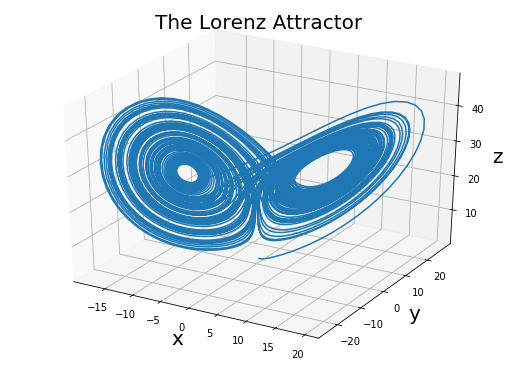

In [2]:
# Generate and plot Lorenz 63 model
tmax, num_samples = 100, 10000
X0 = np.array([0, 1, 1.05]) # Initial condition

L63 = Lorenz63(tmax, X0, num_samples)
L63.plot()

In [3]:
def which_wing(X: np.array, lag: int) -> np.array:
    """ Returns array of 0s and 1s corresponding to whether a point on the attractor lands on the
        left or right wing respectively after time=lag
        Args:
            X: array of shape (3, num_samples)
        
        Output: array of shape (num_samples - lag, )
    """
    x, y, z = X
    return (x[lag:] > 0).astype(int)

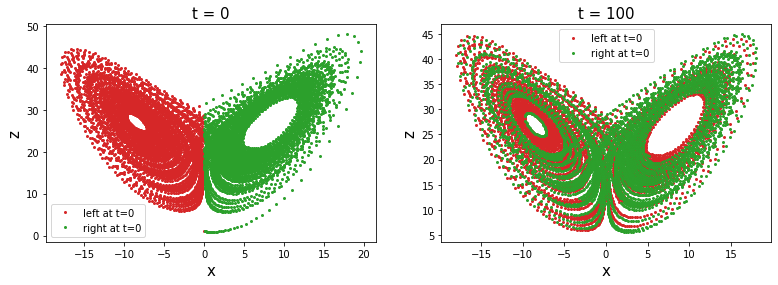

In [85]:
tsteps = 100
X = L63.trajectory
N = L63.num_samples
initial_labels = which_wing(X,lag=0)[:N-tsteps]

left_indices = np.argwhere(initial_labels == 0)
right_indices = np.argwhere(initial_labels == 1)

initially_left_X_t0 = np.array([X[:,i] for i in left_indices]).squeeze()
initially_right_X_t0 = np.array([X[:,i] for i in right_indices]).squeeze()

initially_left_X_t100 = np.array([X[:,i + tsteps] for i in left_indices]).squeeze()
initially_right_X_t100 = np.array([X[:,i + tsteps] for i in right_indices]).squeeze()

initially_left_X = np.stack([initially_left_X_t0, initially_left_X_t100])
initially_right_X = np.stack([initially_right_X_t0, initially_right_X_t100])

# Plot
fig = plt.figure(figsize=(13, 4))
timestamps = [0, tsteps]
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    plt.plot(initially_left_X[i][:,0], initially_left_X[i][:,2], 'o', color='tab:red', ms=2, label=f'left at t={0}')
    plt.plot(initially_right_X[i][:,0], initially_right_X[i][:,2], 'o', color='tab:green', ms=2, label=f'right at t={0}')
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('z', fontsize=15)
    ax.set_title(f't = {timestamps[i]}', fontsize=15)
    ax.legend()

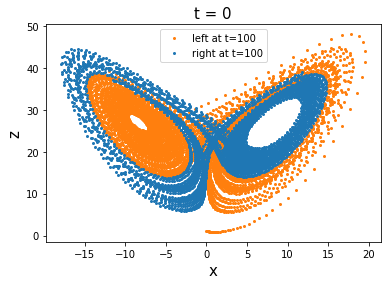

In [93]:
lag = tsteps
labels = which_wing(X,lag=lag)

left_indices = np.argwhere(labels == 0)
right_indices = np.argwhere(labels == 1)

eventually_left_X = np.array([X[:,i] for i in left_indices]).squeeze()
eventually_right_X = np.array([X[:,i] for i in right_indices]).squeeze()

# Plot
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.plot(eventually_left_X[:,0], eventually_left_X[:,2], 'o', color='tab:orange', ms=2, label=f'left at t={tsteps}')
plt.plot(eventually_right_X[:,0], eventually_right_X[:,2], 'o', color='tab:blue', ms=2, label=f'right at t={tsteps}')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('z', fontsize=15)
ax.set_title(f't = 0', fontsize=15)
ax.legend()
plt.show()

## 1. Logistic Regression

In [6]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [7]:
X = X[:,:N-lag].transpose() # Reshape to size (num_samples-lag, 3)
y = labels
train_X, test_X, train_y, test_y = train_test_split(X, labels, test_size=0.2)

In [40]:
model_lr = LogisticRegression()
model_lr.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

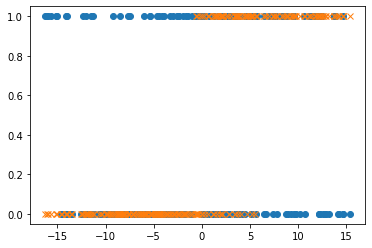

In [92]:
ypred = model_lr.predict(test_X)
plt.plot(test_X[:250,0], test_y[:250], 'o')
plt.plot(test_X[:250,0], ypred[:250], 'x')
plt.show()

In [53]:
accuracy_lr = model_lr.score(test_X, test_y)
print("Accuracy of logistic regression: {:.4f}".format(accuracy_lr))

Accuracy of logistic regression: 0.6475


In [42]:
def extend_features(X):
    """Extend feature space by adding quadratic terms
    Args:
        X: array of size (batch, feature)
    """
    X_ext = X
    dim = X.shape[1]
    quadratic = [X[:,[i]]*X[:,[j]] for i in range(dim) for j in range(i)]
    return np.concatenate([X, *quadratic], axis=1)

model_lr_extended = LogisticRegression()
train_X_extended = extend_features(train_X)
model_lr_extended.fit(train_X_extended, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy of logistic regression with extra quadratic features: 0.7535


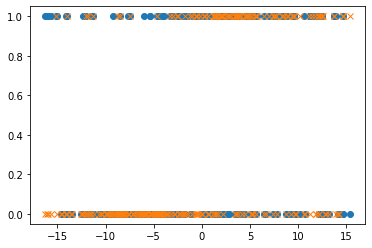

In [91]:
test_X_extended = extend_features(test_X)
accuracy_lr_ext = model_lr_extended.score(test_X_extended, test_y)
print("Accuracy of logistic regression with extra quadratic features: {:.4f}".format(accuracy_lr_ext))

ypred = model_lr_extended.predict(test_X_extended)
plt.plot(test_X[:250,0], test_y[:250], 'o')
plt.plot(test_X[:250,0], ypred[:250], 'x')
plt.show()

## 2. Decision Trees

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [14]:
model_dt = DecisionTreeClassifier()
model_dt.fit(train_X, train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

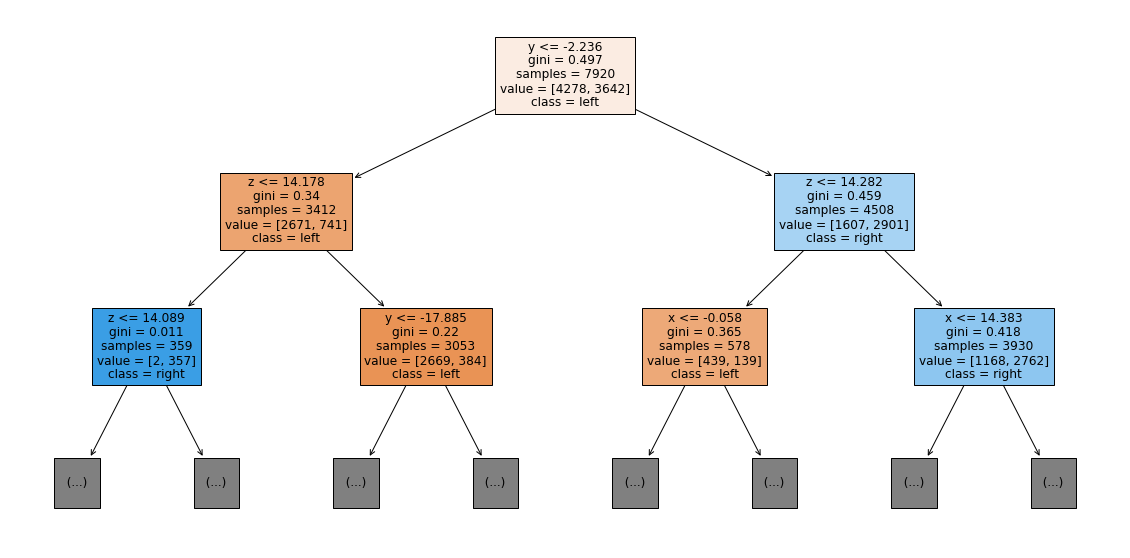

In [15]:
fig = plt.figure(figsize = (20, 10))
sklearn.tree.plot_tree(model_dt,
                       max_depth = 2,
                       feature_names = ['x', 'y', 'z'],
                       class_names = ['left', 'right'],
                       filled = True)
plt.show()

Accuracy of decision tree: 0.9646


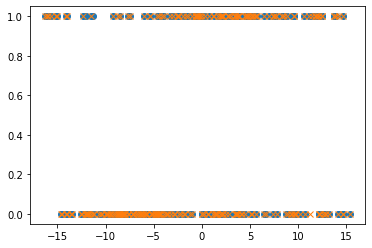

In [98]:
accuracy_dt = model_dt.score(test_X, test_y)
print("Accuracy of decision tree: {:.4f}".format(accuracy_dt))

ypred = model_dt.predict(test_X)
plt.plot(test_X[:250,0], test_y[:250], 'o')
plt.plot(test_X[:250,0], ypred[:250], 'x')
plt.show()

In [18]:
model_rf = RandomForestClassifier(max_depth=15)
model_rf.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

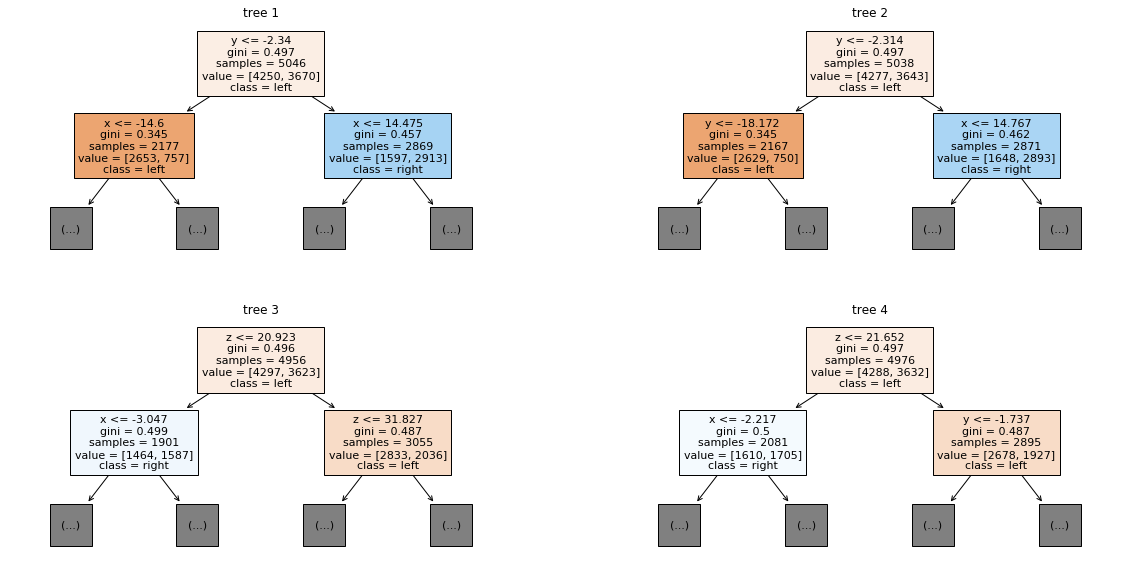

In [96]:
fig = plt.figure(figsize = (20, 10))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    sklearn.tree.plot_tree(model_rf.estimators_[i],
                           max_depth = 1,
                           feature_names = ['x', 'y', 'z'],
                           class_names = ['left', 'right'],
                           filled = True)
    ax.set_title(f'tree {i+1}', fontsize=12)
plt.show()

Accuracy of random forest: 0.9677


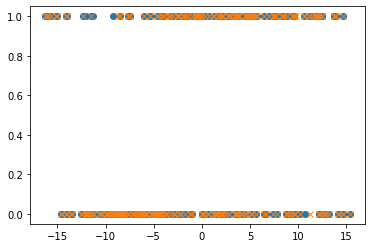

In [97]:
accuracy_rf = model_rf.score(test_X, test_y)
print("Accuracy of random forest: {:.4f}".format(accuracy_rf))

ypred = model_rf.predict(test_X)
plt.plot(test_X[:250,0], test_y[:250], 'o')
plt.plot(test_X[:250,0], ypred[:250], 'x')
plt.show()

## 3. Neural networks

In [22]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [35]:
model_nn = Sequential([
    keras.Input(shape=(3,)),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(1, activation='sigmoid')])

loss_fn = keras.losses.BinaryCrossentropy()
opt = keras.optimizers.Adam(learning_rate=0.001)
model_nn.compile(loss=loss_fn,
                 optimizer='adam',
                 metrics=['accuracy'])

In [36]:
model_nn.fit(train_X, train_y, epochs=10)

Epoch 1/10
248/248 [==============================] - 0s 2ms/step - loss: 0.5354 - accuracy: 0.7265
Epoch 2/10
248/248 [==============================] - 0s 2ms/step - loss: 0.4833 - accuracy: 0.7447
Epoch 3/10
248/248 [==============================] - 0s 2ms/step - loss: 0.4082 - accuracy: 0.8015
Epoch 4/10
248/248 [==============================] - 0s 2ms/step - loss: 0.3452 - accuracy: 0.8578
Epoch 5/10
248/248 [==============================] - 1s 2ms/step - loss: 0.2675 - accuracy: 0.8874
Epoch 6/10
248/248 [==============================] - 0s 2ms/step - loss: 0.2484 - accuracy: 0.8908
Epoch 7/10
248/248 [==============================] - 0s 2ms/step - loss: 0.2036 - accuracy: 0.9095
Epoch 8/10
248/248 [==============================] - 1s 2ms/step - loss: 0.1812 - accuracy: 0.9229
Epoch 9/10
248/248 [==============================] - 0s 2ms/step - loss: 0.1776 - accuracy: 0.9169
Epoch 10/10
248/248 [==============================] - 1s 2ms/step - loss: 0.1743 - accuracy: 0.9242

62/62 [==============================] - 0s 4ms/step - loss: 0.2261 - accuracy: 0.9162


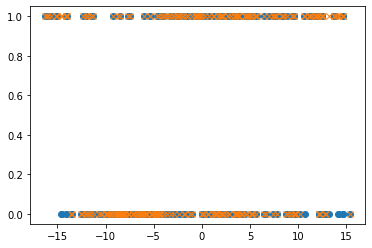

In [94]:
loss_nn, accuracy_nn = model_nn.evaluate(test_X, test_y)

# plot
ypred = model_nn(test_X)
ypred_binary = np.array([0 if p < 0.5 else 1 for p in ypred])
plt.plot(test_X[:250,0], test_y[:250], 'o')
plt.plot(test_X[:250,0], ypred_binary[:250], 'x')
plt.show()